<a href="https://colab.research.google.com/github/google/tunix/blob/main/examples/qlora_demo.ipynb" ><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install necessary libraries

In [1]:
!pip install -q kagglehub

!pip install -q tensorflow
!pip install -q tensorboardX
!pip install -q grain
!pip install -q jax==0.6.2 jaxlib==0.6.2
# !pip install -q git+https://github.com/google/tunix
! pip install -q ~/tunix/
!pip install -q git+https://github.com/google/qwix

!pip uninstall -q -y flax
!pip install -q git+https://github.com/google/flax.git@5d5c907d1b5f45c97138289d5aa2e2e8452bf52e


!pip install -q tensorflow-datasets

!pip install -q git+https://github.com/AI-Hypercomputer/pathways-utils.git


In [2]:
# # If you want to upload your metrics to Weights & Biases, please install the package and login. Make sure to install `wandb` before importing `tunix`.
# !pip install wandb

# import wandb
# wandb.login()

If `wandb` is installed, you'll see a message like the one below when you start the experiment:

```
Tracking run with wandb version 0.21.0
Run data is saved locally in /content/wandb/run-20250717_224322-kmvoi0ho
Syncing run 2025-07-17_22-43-22 to Weights & Biases (docs)
View project at https://wandb.ai/<wandb_username>/tunix?apiKey=<api_key>
View run at https://wandb.ai/<wandb_username>/tunix/runs/kmvoi0ho?apiKey=<api_key>
Do NOT share these links with anyone. They can be used to claim your runs.
```

After clicking the link, you will be directed to the following Weights & Biases metrics page which contain train metrics, eval metrics, system metrics, and various custom metric you wish to report:

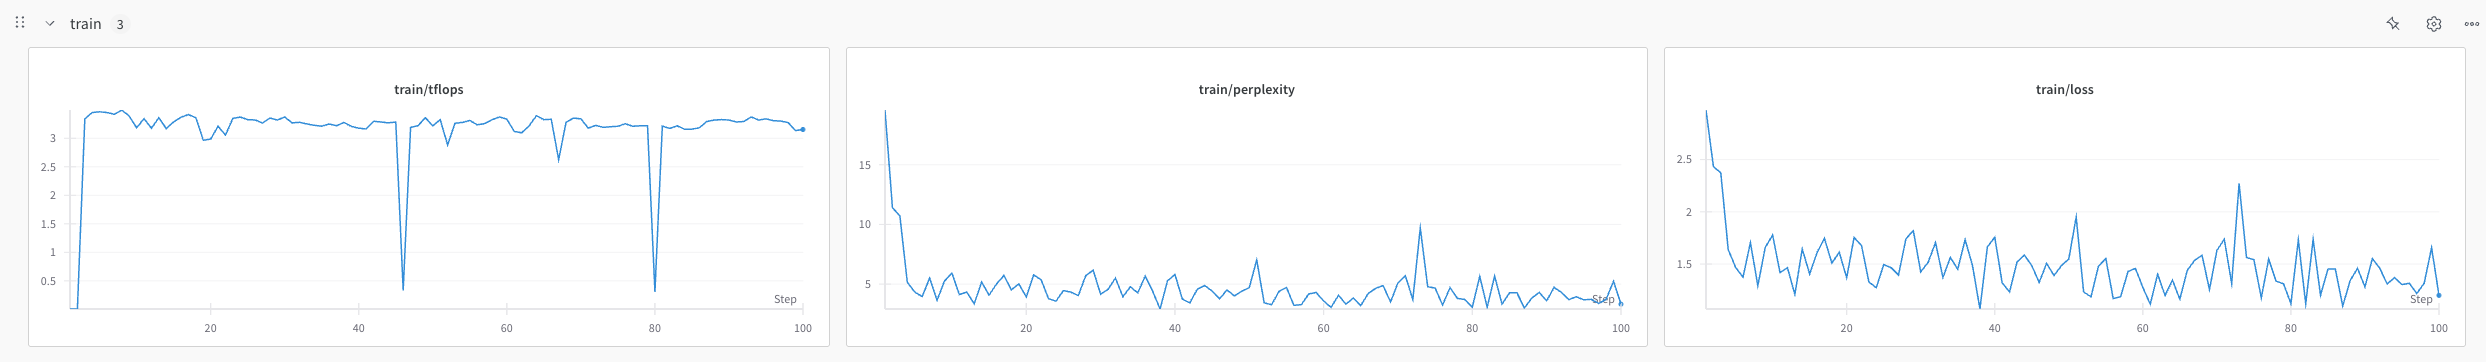

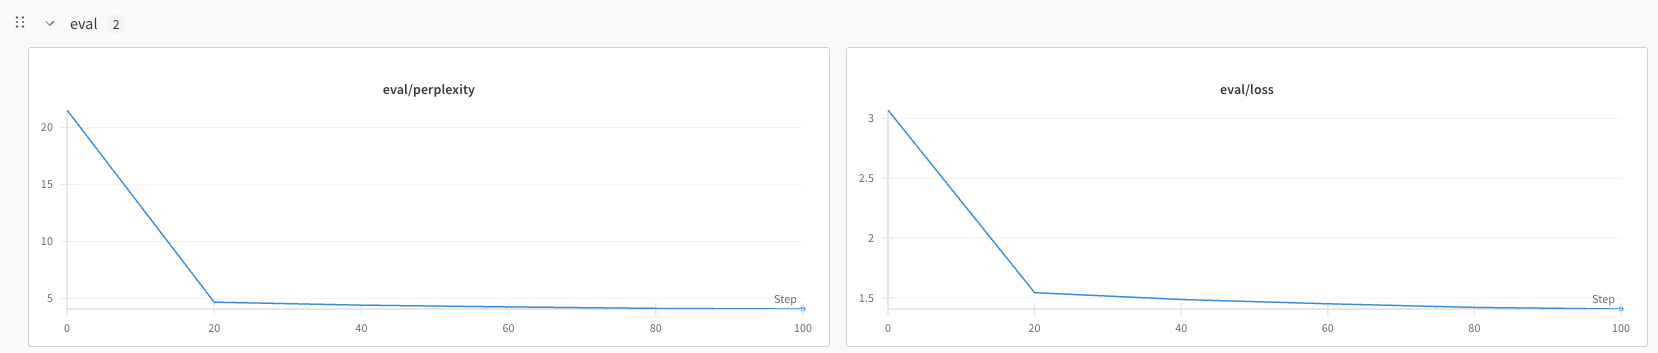

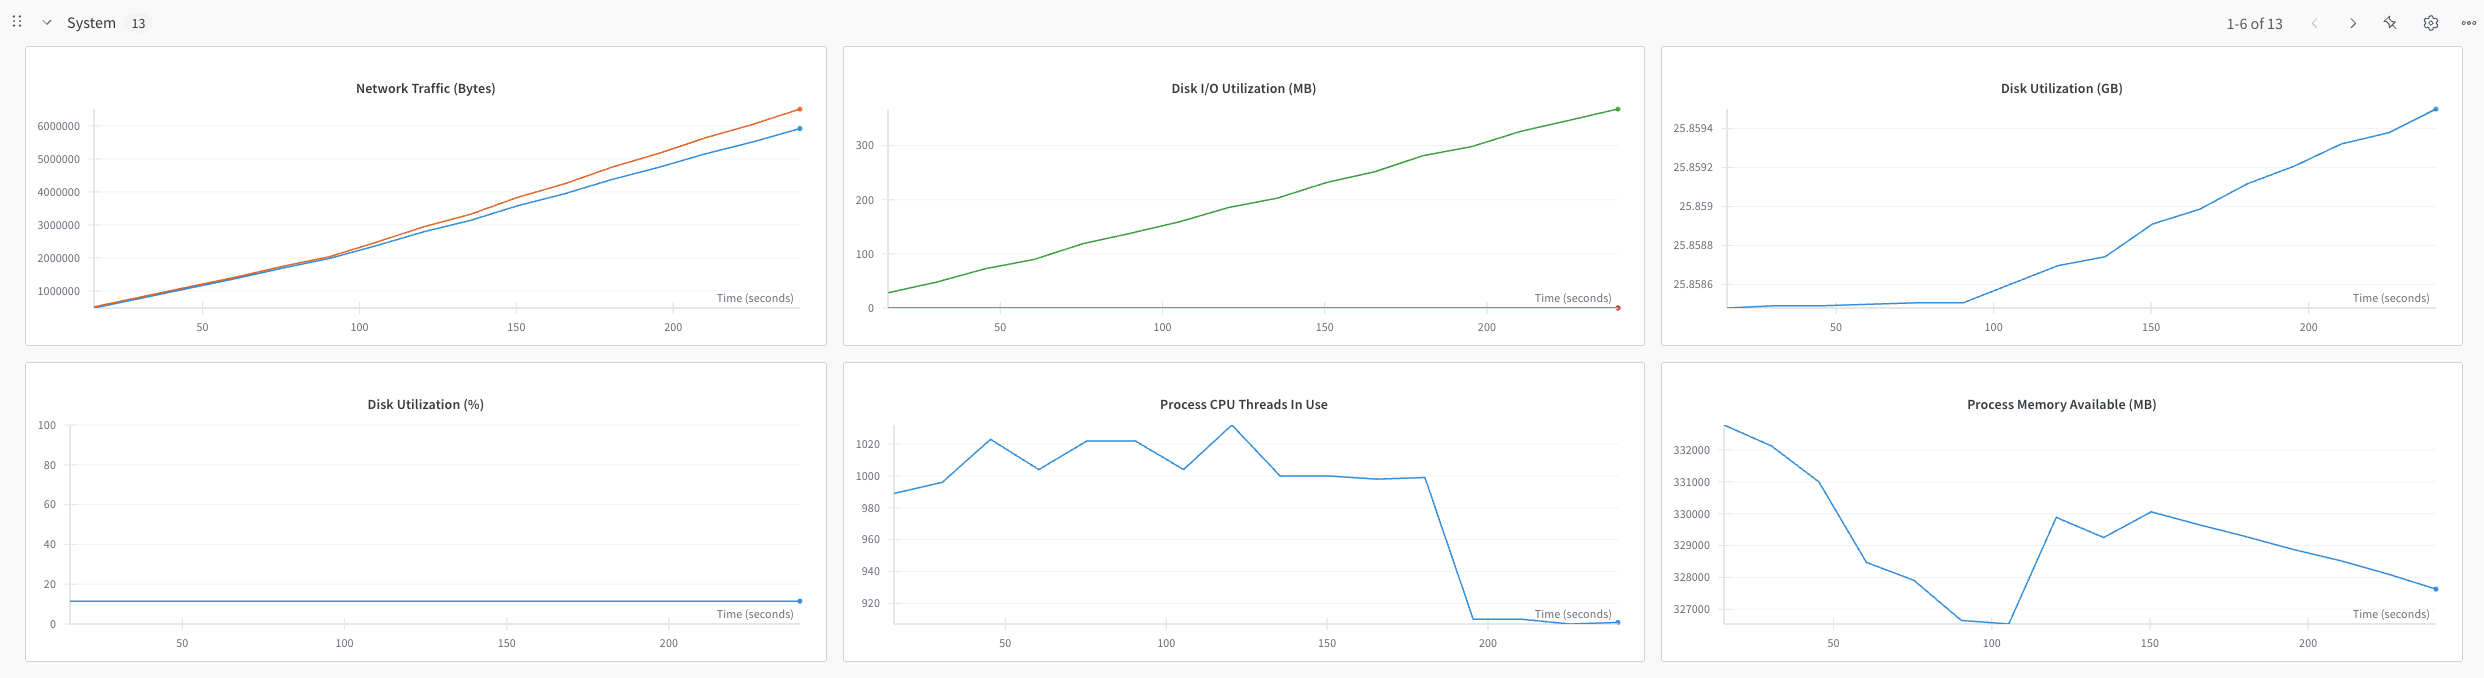

In [3]:
!pip install tensorflow-datasets
!pip install aqtp
!pip install pillow>=11.1.0
!pip install pillow
!pip install omegaconf
!pip install google-cloud-storage

In [4]:
!pip install tensorflow_text transformers tiktoken

## Imports

In [5]:
import gc
import os
import time

from flax import nnx
import jax
import jax.numpy as jnp
import kagglehub
import optax
from orbax import checkpoint as ocp
from qwix import lora
from tunix.generate import sampler as sampler_lib
from tunix.models.gemma import data as data_lib
from tunix.models.gemma import gemma as gemma_lib
from tunix.models.gemma import params as params_lib
from tunix.sft import metrics_logger
from tunix.sft import peft_trainer

## Hyperparameters

In [6]:
# Data
BATCH_SIZE = 16

# Model
MESH = [(1, 8), ("fsdp", "tp")]
# LoRA
RANK = 16
ALPHA = 2.0

# Train
MAX_STEPS = 100
EVAL_EVERY_N_STEPS = 20
NUM_EPOCHS = 3


# Checkpoint saving
INTERMEDIATE_CKPT_DIR = "~/qlora_expt/content/intermediate_ckpt/"
CKPT_DIR = "~/qlora_expt/content/ckpts/"
PROFILING_DIR = "~/qlora_expt/content/profiling/"

## Load Gemma 2B

To load the model, you need to be on [Kaggle](https://www.kaggle.com/) and need
to have agreed to the Gemma license
[here](https://www.kaggle.com/models/google/gemma/flax/).

In [7]:
# Log in
# if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
  # kagglehub.login()


In [8]:
kaggle_ckpt_path = kagglehub.model_download("google/gemma/flax/2b")

In [9]:
# # This is a workaround. The checkpoints on Kaggle don't work with NNX. So, we
# # load the model, save the checkpoint locally, and then reload the model
# # (sharded).
# params = params_lib.load_and_format_params(os.path.join(kaggle_ckpt_path, "2b"))
# gemma = gemma_lib.Transformer.from_params(params, version="2b")
# checkpointer = ocp.StandardCheckpointer()
# _, state = nnx.split(gemma)
# checkpointer.save(os.path.join(INTERMEDIATE_CKPT_DIR, "state"), state)

In [10]:
# # # Wait for the ckpt to save successfully.
# time.sleep(60)

In [11]:
# # Delete the intermediate model to save memory.
# del params
# del gemma
# del state
# gc.collect()

In [12]:
import sys
import os

# add the parent directory (one level up) to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../maxtext')))

# ! pip install -r ../../maxtext/requirements.txt

import MaxText as mt
from MaxText import pyconfig

2025-08-01 23:12:41.595954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754089961.608215 1845531 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754089961.611901 1845531 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754089961.622177 1845531 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754089961.622190 1845531 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754089961.622192 1845531 computation_placer.cc:177] computation placer alr

In [13]:
from MaxText.integration.tunix.tunix_adaptor import TunixMaxTextLlama
from flax import linen as nn
! pip install -q ~/tunix/

def get_ref_maxtext_model():

  #python3 -m MaxText.train MaxText/configs/base.yml base_output_directory=${BASE_OUTPUT_DIRECTORY} dataset_path=${DATASET_PATH} tokenizer_path=assets/tokenizer.gemma load_parameters_path=${CONVERTED_CHECKPOINT} per_device_batch_size=1 run_name=${FINETUNE_RUN_NAME} max_target_length=8192 steps=10 async_checkpointing=false model_name=gemma-2b checkpoint_period=5

  #TODO: @mazumdera: change this to use Gemma2-2b-it
  config = pyconfig.initialize(
      ["", "../../maxtext/MaxText/configs/base.yml"], #TODO: @mazumdera: why decode.py?
      base_output_directory="gs://dummy_output_dir",  # This is not used in Tunix.
      run_name="test-tunix-maxtext-llama3-8b",
      # dataset_path=we use Tunix's dataset
      load_parameters_path="gs://maxtext-gemma/2b/", #TODO: @mazumdera: change this to use checkpoint
      # tokenizer_type="tiktoken",
      # tokenizer_path="assets/tokenizer_llama3.tiktoken",
      tokenizer_path="../../maxtext/assets/tokenizer.gemma",
      per_device_batch_size=1,
      max_target_length=8192,
      steps=10,
      async_checkpointing="false",
      # model_name="llama3.1-8b",
      model_name="gemma-2b",
      checkpoint_period=5,
      skip_jax_distributed_system="true",
      weight_dtype="bfloat16",
  )
  
  # checkpoint = mt.checkpointing.load_params_from_path(
  #     load_parameters_from_path="gs://maxtext-gemma/2b/",
  #     abstract_unboxed_params=None,
  #     checkpoint_storage_concurrent_gb=None,
  # )
  checkpoint = {}

  def create_model(config):
    return mt.from_pretrained(config, rngs=nnx.Rngs(params=0, dropout=1))

  model = nnx.eval_shape(create_model, config=config)

  @nnx.jit
  def partial_init(checkpoint, config):
    model = create_model(config)
    nnx.update(model, checkpoint)
    # shard model
    state = nnx.state(model)
    specs = nnx.get_partition_spec(state)
    state = jax.lax.with_sharding_constraint(state, specs)
    nnx.update(model, state)
    return model

  with jax.sharding.use_mesh(model.mesh), nn.logical_axis_rules(config.logical_axis_rules):
    model = partial_init(checkpoint, config)
  print(model)

  
  tunix_model = TunixMaxTextLlama(
        base_model=model,
        use_attention_mask=False,  # trust Tunix loss masking
    )
  mesh  = tunix_model.base.mesh
  
  #TODO: @mazumdera: change this to use llama3.1-8b
  # model_config = None
  # We can continue to use Tunix's model_config
  model_config = gemma_lib.TransformerConfig.gemma2_2b()

  # Add these lines to properly get the graph definition and state
  graphdef, state = nnx.split(tunix_model)
  tunix_model = nnx.merge(graphdef, state)  # Recreate model in proper NNX format
    
  
  return tunix_model, mesh, model_config

In [14]:
# Base model
# gemma, mesh, model_config = get_base_model(
#     ckpt_path=os.path.join(INTERMEDIATE_CKPT_DIR, "state")
# )

gemma, mesh, model_config = get_ref_maxtext_model()
# gemma_maxtext_nnx = nnx.bridge.ToNNX(gemma)
# Instead of:
nnx.display(gemma)

# Use:
print("Model initialized successfully")
print(f"Model mesh shape: {mesh.shape}")
print(f"Model config: {model_config}")

Updating keys from env and command line: ['run_name', 'model_name', 'load_parameters_path', 'async_checkpointing', 'checkpoint_period', 'weight_dtype', 'base_output_directory', 'tokenizer_path', 'per_device_batch_size', 'steps', 'skip_jax_distributed_system', 'max_target_length']
Running Model: gemma-2b
Updating following parameters in config

base_emb_dim: 2048
base_num_query_heads: 8
base_num_kv_heads: 1
base_mlp_dim: 16384
base_num_decoder_layers: 18
head_dim: 256
mlp_activations: ['gelu', 'linear']
vocab_size: 256128
decoder_block: gemma
normalization_layer_epsilon: 1e-06
logits_via_embedding: True
Updating keys from model: ['base_emb_dim', 'base_num_query_heads', 'base_num_kv_heads', 'base_mlp_dim', 'base_num_decoder_layers', 'head_dim', 'mlp_activations', 'vocab_size', 'decoder_block', 'normalization_layer_epsilon', 'logits_via_embedding']
Skipping jax distributed system due to skip_jax_distributed_system=True flag.


Not using emergency checkpoint, ignoring local_checkpoint_directory, local_checkpoint_period, use_replicator_service and replicator_backup_interval_minutes
dataset_type set to tfds, will use keys['dataset_path']='' and keys['dataset_name']='c4/en:3.0.1'
Config param activations_in_float32: False
Config param adam_b1: 0.9
Config param adam_b2: 0.95
Config param adam_eps: 1e-08
Config param adam_eps_root: 0.0
Config param adam_weight_decay: 0.1
Config param add_bos: True
Config param add_eos: True
Config param allow_split_physical_axes: False
Config param ar_cache_axis_order: 1,2,0,3
Config param async_checkpointing: False
Config param attention: autoselected
Config param attention_type: global
Config param attn_logits_soft_cap: None
Config param autoregressive_decode_assert: 
Config param base_emb_dim: 2048
Config param base_mlp_dim: 16384
Config param base_moe_mlp_dim: 7168
Config param base_num_decoder_layers: 18
Config param base_num_kv_heads: 1
Config param base_num_query_heads: 8
C

/home/mazumdera_google_com/venv-py311/lib/python3.11/site-packages/treescope/renderers.py:251: UserWarning: Ignoring error inside wrapper hook <function replace_with_canonical_aliases at 0x700b2aff8540>:
Traceback (most recent call last):
  File "/home/mazumdera_google_com/venv-py311/lib/python3.11/site-packages/treescope/renderers.py", line 225, in _render_subtree
    postprocessed_result = hook(
                           ^^^^^
  File "/home/mazumdera_google_com/venv-py311/lib/python3.11/site-packages/treescope/_internal/handlers/canonical_alias_postprocessor.py", line 78, in replace_with_canonical_aliases
    maybe_alias = canonical_aliases.lookup_alias(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mazumdera_google_com/venv-py311/lib/python3.11/site-packages/treescope/canonical_aliases.py", line 317, in lookup_alias
    unwrapped = inspect.unwrap(the_object)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/inspect.py", line 756, in unwrap
   

Model initialized successfully
Model mesh shape: OrderedDict([('data', 1), ('stage', 1), ('fsdp', 1), ('fsdp_transpose', 1), ('sequence', 1), ('context', 1), ('context_autoregressive', 1), ('tensor', 1), ('tensor_transpose', 1), ('tensor_sequence', 1), ('expert', 1), ('autoregressive', 1)])
Model config: TransformerConfig(num_layers=26, num_embed=256128, embed_dim=2304, hidden_dim=9216, num_heads=8, head_dim=256, num_kv_heads=4, final_logit_softcap=30.0, use_post_attn_norm=True, use_post_ffw_norm=True, attention_types=(<AttentionType.LOCAL_SLIDING: 2>, <AttentionType.GLOBAL: 1>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.GLOBAL: 1>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.GLOBAL: 1>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.GLOBAL: 1>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.GLOBAL: 1>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.GLOBAL: 1>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.GLOBAL: 1>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType

In [15]:
gemma

TunixMaxTextLlama( # Param: 2,506,434,560 (5.0 GB), RngState: 4 (24 B), Total: 2,506,434,564 (5.0 GB)
  base=TransformerNNX( # Param: 2,506,434,560 (5.0 GB), RngState: 4 (24 B), Total: 2,506,434,564 (5.0 GB)
    config=<MaxText.pyconfig.HyperParameters object at 0x700a0e14a650>,
    decoder=ToNNX( # Param: 1,981,884,416 (4.0 GB), RngState: 4 (24 B), Total: 1,981,884,420 (4.0 GB)
      decoder_norm={'scale': Param( # 2,048 (4.1 KB)
        value=Array(shape=(2048,), dtype=dtype(bfloat16)),
        mesh=None,
        sharding=('norm',),
        sharding_rules=None,
        linen_meta_type=LogicallyPartitioned
      )},
      layers={'mlp': {'wi_0': {'kernel': Param( # 603,979,776 (1.2 GB)
        value=Array(shape=(2048, 18, 16384), dtype=dtype(bfloat16)),
        mesh=None,
        sharding=('embed', 'layers', 'mlp'),
        sharding_rules=None,
        linen_meta_type=LogicallyPartitioned
      )}, 'wi_1': {'kernel': Param( # 603,979,776 (1.2 GB)
        value=Array(shape=(2048, 18, 1

In [ ]:
import jax.numpy as jnp
import os
# I'm assuming you have these imports in your script.
# If not, you'll need to add them.
# from tunix.models.gemma import gemma as gemma_lib
# from path.to import data_lib

TEMP_BATCH_SIZE = 1

# Assuming gemma is a pre-loaded instance of gemma_lib.Transformer
# and data_lib is available.
gemma_tokenizer = data_lib.GemmaTokenizer(
    os.path.join(kaggle_ckpt_path, "tokenizer.model")
)

tokens = gemma_tokenizer.encode("hakuna matata")
# tokens = [gemma_tokenizer.bos_id()]+gemma_tokenizer.encode("The color of the sky is blue but")

repeated_tokens = jnp.repeat(jnp.array(tokens)[None, :], TEMP_BATCH_SIZE, axis=0)
positions = jnp.repeat(jnp.arange(0, len(tokens))[None, :], TEMP_BATCH_SIZE, axis=0)

# --- FIX STARTS HERE ---

# The Gemma model requires an attention mask. Passing `None` causes an error.
# We need to create a causal attention mask for the prefill step.

# 1. Create a boolean mask for the input tokens (True for valid tokens, False for padding).
#    Assuming `gemma_tokenizer.pad_id()` exists. If not, and there's no padding,
#    `jnp.ones_like(repeated_tokens, dtype=jnp.bool_)` would also work.
#    A common pad_id is 0.
pad_id = gemma_tokenizer.pad_id()
input_mask = (repeated_tokens != pad_id)

# 2. Create a causal attention mask from the input mask.
#    This prevents the model from attending to future tokens.
attention_mask = gemma_lib.make_causal_attn_mask(input_mask)

# 3. Call the model with the correct attention mask.
gemma_output_logits, _ = gemma(repeated_tokens, positions, cache=None, attention_mask=attention_mask)  # Test the model to ensure it works

# --- FIX ENDS HERE ---

# The commented out line below would also need a proper attention_mask.
# For example:
# dummy_tokens = jnp.ones((TEMP_BATCH_SIZE, 16), jnp.int32)
# dummy_positions = jnp.repeat(jnp.arange(0,16)[None,:], TEMP_BATCH_SIZE, axis=0)
# dummy_mask = gemma_lib.make_causal_attn_mask(jnp.ones_like(dummy_tokens, dtype=jnp.bool_))
# gemma_output = gemma(dummy_tokens, dummy_positions, cache=None, attention_mask=dummy_mask)

print("Successfully ran the model!")
print("Output shape:", gemma_output_logits.shape)

print(f"Tokens: {tokens}")
print(f"positions: {positions}")


inputs=[[[-1.35156 -0.482422 -1.30469 ... -0.667969 -0.152344 1.54688]
  [-0.353516 1.49219 -0.503906 ... -1.21875 1.28125 -1.57812]
  [0.609375 0.162109 -1.30469 ... -0.667969 -0.439453 -0.0344238]
  [-0.644531 -2.32812 1.04688 ... -1.03125 1.625 -0.621094]]]
lnx=[[[-1.375 -0.490234 -1.32031 ... -0.675781 -0.154297 1.57031]
  [-0.355469 1.5 -0.507812 ... -1.22656 1.28906 -1.58594]
  [0.597656 0.15918 -1.28125 ... -0.652344 -0.429688 -0.0336914]
  [-0.644531 -2.32812 1.04688 ... -1.03125 1.625 -0.621094]]]
attention_lnx=[[[-0.617188 -0.996094 0.318359 ... -1.46875 0.585938 -0.371094]
  [0.443359 -0.90625 -0.9375 ... 0.412109 0.824219 -0.851562]
  [0.255859 -0.228516 0.0761719 ... -0.271484 0.644531 -0.0152588]
  [1.10938 0.466797 -0.90625 ... 0.203125 0.542969 -1.10156]]]
attn_output=[[[-1.39062 -1.03906 -0.695312 ... -1.50781 0.306641 0.828125]
  [0.0698242 0.455078 -1.11719 ... -0.625 1.63281 -1.88281]
  [0.699219 -0.0534668 -0.992188 ... -0.757812 0.165039 -0.0400391]
  [0.400391 -1

In [43]:
print(gemma_output_logits.shape)
jnp.argmax(gemma_output_logits, axis=2)  

(1, 4, 256128)


Array([[17964,  3722,  1926,   784]], dtype=int32)

In [37]:
last_token_logits = gemma_output_logits[:, -1, :]
predicted_token_id = jnp.argmax(last_token_logits, axis=-1)
# Decode the token ID to see the predicted word.
# Since TEMP_BATCH_SIZE is 1, we can just grab the first element.
next_token_id = predicted_token_id[0]
predicted_token_text = gemma_tokenizer.decode([int(next_token_id)])

print(f"\nPredicted next token ID: {next_token_id}")
print(f"Predicted next token: '{predicted_token_text}'")


Predicted next token ID: 708
Predicted next token: ' are'


In [19]:
gemma_output_logits[0][0,7]

Array(1.1875, dtype=float32)

In [20]:
# def get_base_model(ckpt_path):

#   model_config = gemma_lib.TransformerConfig.gemma_2b()
#   mesh = jax.make_mesh(*MESH)
#   abs_gemma: nnx.Module = nnx.eval_shape(
#       lambda: gemma_lib.Transformer(model_config, rngs=nnx.Rngs(params=0))
#   )
#   abs_state = nnx.state(abs_gemma)
#   abs_state = jax.tree.map(
#       lambda a, s: jax.ShapeDtypeStruct(a.shape, jnp.bfloat16, sharding=s),
#       abs_state,
#       nnx.get_named_sharding(abs_state, mesh),
#   )
#   checkpointer = ocp.StandardCheckpointer()
#   restored_params = checkpointer.restore(ckpt_path, target=abs_state)

#   graph_def, _ = nnx.split(abs_gemma)
#   gemma = nnx.merge(graph_def, restored_params)
#   return gemma, mesh, model_config

## Prompt the model

Let's see how the model performs on the English-French translation task.

In [21]:
gemma_tokenizer = data_lib.GemmaTokenizer(
    os.path.join(kaggle_ckpt_path, "tokenizer.model")
)

from MaxText.input_pipeline import _input_pipeline_utils
from MaxText.globals import PKG_DIR

# gemma_tokenizer = _input_pipeline_utils.get_tokenizer(
#         os.path.join(os.path.dirname(PKG_DIR), "assets", "tokenizer_llama3.tiktoken"),
#         "tiktoken",
#         add_bos=True,
#         add_eos=False,
#     )
#     )
# gemma_tokenizer = data_lib.GemmaTokenizer(
# )

sampler = sampler_lib.Sampler(
    transformer=gemma,
    tokenizer=gemma_tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

input_batch = [
    "The color of the sky is \n",
    "Translate this into French:\nHello, my name is Morgane.\n",
    "Translate this into French:\nThis dish is delicious!\n",
    "Translate this into French:\nI am a student.\n",
    "Translate this into French:\nHow's the weather today?\n",
]

out_data = sampler(
    input_strings=input_batch,
    total_generation_steps=10,  # The number of steps performed when generating a response.
    echo=True,  # Whether to echo the input string in the output.
)

for input_string, out_string, tokens in zip(input_batch, out_data.text, out_data.tokens):
  print(f"----------------------")
  print(f"Prompt:\n{input_string}")
  print(f"Output:\n{out_string}")
  print(f"Tokens:\n{tokens}")

inputs=[[[1.15625 -0.353516 1.4375 ... -1.57812 0.0245361 -0.644531]
  [1.15625 -0.353516 1.4375 ... -1.57812 0.0245361 -0.644531]
  [1.15625 -0.353516 1.4375 ... -1.57812 0.0245361 -0.644531]
  ...
  [0.539062 -0.333984 0.123047 ... -0.439453 -0.796875 2.51562]
  [-1.03125 -0.621094 -0.292969 ... -0.271484 0.8125 0.785156]
  [-0.132812 -1 -0.292969 ... -0.192383 1.01562 1.28125]]

 [[-0.550781 1.32812 0.304688 ... -0.691406 0.921875 -1.73438]
  [0.0245361 1.15625 0.515625 ... 0.472656 1.04688 1.625]
  [-1 1.24219 -1.83594 ... 1.19531 -0.824219 -0.132812]
  ...
  [0.472656 0.261719 -0.0146484 ... -0.171875 2.01562 0.65625]
  [0.5625 0.632812 -0.292969 ... 2.51562 -0.333984 0.123047]
  [-0.132812 -1 -0.292969 ... -0.192383 1.01562 1.28125]]

 [[1.15625 -0.353516 1.4375 ... -1.57812 0.0245361 -0.644531]
  [1.15625 -0.353516 1.4375 ... -1.57812 0.0245361 -0.644531]
  [1.15625 -0.353516 1.4375 ... -1.57812 0.0245361 -0.644531]
  ...
  [-0.0344238 0.103027 0.494141 ... -1.65625 -0.152344 -0

In [22]:
gemma_tokenizer.encode("The color\n")
gemma_tokenizer.decode([235336    , 108 ])

'?\n'

In [23]:
sampler.transformer_state

State({
  'base': {
    'decoder': {
      'decoder_norm': {
        'scale': Param( # 2,048 (4.1 KB)
          value=Array([1, 1, 1, ..., 1, 1, 1], dtype=bfloat16),
          mesh=None,
          sharding=('norm',),
          sharding_rules=None,
          linen_meta_type=LogicallyPartitioned
        )
      },
      'layers': {
        'mlp': {
          'wi_0': {
            'kernel': Param( # 603,979,776 (1.2 GB)
              value=Array([[[-0.0349121, 0.019165, 0.0178223, ..., -0.00421143, 0.0117188,
                       -0.00521851],
                      [-0.0375977, 0.0284424, -0.00469971, ..., 0.0314941, -0.017334,
                       0],
                      [0.0032196, 0.0111694, 0.00750732, ..., 0.0314941, -0.0148315,
                       -0.0197754],
                      ...,
                      [0.00723267, -0.046875, 0.0303955, ..., 0.0441895, 0.00370789,
                       -0.0090332],
                      [0.00723267, 0.00799561, 0.00521851, ..., -0.00

## Apply LoRA/QLoRA to the model

In [24]:
def get_lora_model(base_model, mesh):
  lora_provider = lora.LoraProvider(
      module_path=".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj",
      rank=RANK,
      alpha=ALPHA,
      # comment the two args below for LoRA (w/o quantisation).
      weight_qtype="nf4",
      tile_size=256,
  )

  model_input = base_model.get_model_input()
  lora_model = lora.apply_lora_to_model(
      base_model, lora_provider, **model_input
  )

  with mesh:
    state = nnx.state(lora_model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(lora_model, sharded_state)

  return lora_model

In [25]:
# # LoRA model
# lora_gemma = get_lora_model(gemma, mesh=mesh)
# nnx.display(lora_gemma)

## Load Datasets for SFT Training

In [26]:
# Loads the training and validation datasets
train_ds, validation_ds = data_lib.create_datasets(
    dataset_name='mtnt/en-fr',
    # Uncomment the line below to use a Hugging Face dataset.
    # Note that this requires upgrading the 'datasets' package and restarting
    # the Colab runtime.
    # dataset_name='Helsinki-NLP/opus-100',
    global_batch_size=BATCH_SIZE,
    max_target_length=256,
    num_train_epochs=NUM_EPOCHS,
    tokenizer=gemma_tokenizer,
)


def gen_model_input_fn(x: peft_trainer.TrainingInput):
  pad_mask = x.input_tokens != gemma_tokenizer.pad_id()
  positions = gemma_lib.build_positions_from_mask(pad_mask)
  attention_mask = gemma_lib.make_causal_attn_mask(pad_mask)
  return {
      'input_tokens': x.input_tokens,
      'input_mask': x.input_mask,
      'positions': positions,
      'attention_mask': attention_mask,
  }

## SFT Training

### Training with full weights

In [27]:
logging_option = metrics_logger.MetricsLoggerOptions(
    log_dir="/tmp/tensorboard/full", flush_every_n_steps=20
)
training_config = peft_trainer.TrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    metrics_logging_options=logging_option,
)
trainer = peft_trainer.PeftTrainer(gemma, optax.adamw(1e-5), training_config)
trainer = trainer.with_gen_model_input_fn(gen_model_input_fn)

with jax.profiler.trace(os.path.join(PROFILING_DIR, "full_training")):
  with mesh:
    trainer.train(train_ds, validation_ds)

wandb: (1) Private W&B dashboard, no account required
wandb: (2) Use an existing W&B account
wandb: WARNING Invalid choice
wandb: WARNING Invalid choice
wandb: You chose 'Private W&B dashboard, no account required'
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /home/mazumdera_google_com/.netrc
wandb: Currently logged in as: anony-mouse-863749125460230603 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


ValueError: Resource axis: norm of PartitionSpec('norm',) is not found in mesh: ('data', 'stage', 'fsdp', 'fsdp_transpose', 'sequence', 'context', 'context_autoregressive', 'tensor', 'tensor_transpose', 'tensor_sequence', 'expert', 'autoregressive').

### Training with LoRA/QLoRA

In [ ]:
# Restart Colab runtime.

training_config = peft_trainer.TrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    checkpoint_root_directory=CKPT_DIR,
)
lora_trainer = peft_trainer.PeftTrainer(
    lora_gemma, optax.adamw(1e-3), training_config
).with_gen_model_input_fn(gen_model_input_fn)

with jax.profiler.trace(os.path.join(PROFILING_DIR, "peft")):
  with mesh:
    lora_trainer.train(train_ds, validation_ds)

### Compare profile results of different training

<font size=3>Setup<font>           | <font size=3>Train Step Time<font> | <font size=3>Peak Memory Usage<font>
---------------------------------- | ---------------------------------- | ------------------------------
<font size=3>Full weights<font>        |   <font size=3>~1.22 s<font>     |   <font size=3>43.26 GiB<font>
<font size=3>QLoRA<font>        |   <font size=3>~1.19 s<font>     |   <font size=3>28.14 GiB<font>

## Generate with the LoRA/QLoRA model

The QLoRA model still cannot do English-to-French translation properly since we
only trained for 100 steps. If you train it for longer, you will see better
results.

In [ ]:
gemma_tokenizer = data_lib.GemmaTokenizer(
    os.path.join(kaggle_ckpt_path, "tokenizer.model")
)

sampler = sampler_lib.Sampler(
    transformer=lora_gemma,
    tokenizer=gemma_tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

input_batch = [
    "Translate this into French:\nHello, my name is Morgane.\n",
    "Translate this into French:\nThis dish is delicious!\n",
    "Translate this into French:\nI am a student.\n",
    "Translate this into French:\nHow's the weather today?\n",
]

out_data = sampler(
    input_strings=input_batch,
    total_generation_steps=10,  # The number of steps performed when generating a response.
)

for input_string, out_string in zip(input_batch, out_data.text):
  print(f"----------------------")
  print(f"Prompt:\n{input_string}")
  print(f"Output:\n{out_string}")